# What is this project about?

Besides playing professional Basketball I like watching and analysing NBA players and games. That is why I would like my first project to be about NBA analytics. 
In this work i would like to build up a model which predicts the salaries of NBA Players using multiple Stats (like points/rebounds/assists per game) of the previous two NBA Seasons as input variables.

## Import packages and data

The data I use are the NBA-Player salaries of the season 2019/20 and their stats of the seasons 2017/18 and 2018/19. 

In [1]:
# Data Manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import missingno as msno

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import model_selection, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Other packages
from scipy.stats import norm
from scipy import stats

# Import data
df_salary = pd.read_csv('../input/nba-player-salaries-as-at-2020/NBA Players Salaries 1920.csv')
df_stats1718 = pd.read_csv('../input/nba-players-stats-2016-2017/NBA Players Stats 201718.csv')
df_stats1819 = pd.read_csv('../input/nba-players-stats-2016-2017/NBA Players Stats 201819.csv')
df_list = [df_stats1718, df_stats1819, df_salary]

# 1. Data Cleaning

## How does our data look like?

Let us look at the first five rows of the datasets.

In [2]:
# Salary
df_salary.head()

,Rk,Player,Tm,2019-20,2020-21,2021-22,2022-23,2023-24,2024-25,Signed Using,Guaranteed
0,1,Stephen Curry\curryst01,GSW,40231758.00 $,43006362.00 $,45780966.00 $,NaN,NaN,NaN,Bird Rights,129019086.00 $
1,2,Chris Paul\paulch01,OKC,38506482.00 $,41358814.00 $,44211146.00 $,NaN,NaN,NaN,Bird Rights,79865296.00 $
2,3,Russell Westbrook\westbru01,HOU,38178000.00 $,41006000.00 $,43848000.00 $,46662000.00 $,NaN,NaN,Bird Rights,123032000.00 $
3,4,John Wall\walljo01,WAS,37800000.00 $,40824000.00 $,43848000.00 $,46872000.00 $,NaN,NaN,Bird Rights,122472000.00 $
4,5,James Harden\hardeja01,HOU,37800000.00 $,40824000.00 $,43848000.00 $,46872000.00 $,NaN,NaN,Bird Rights,122472000.00 $


In [3]:
# Season Stats 17/18
df_stats1718.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,24,OKC,75,8,15.1,1.5,3.9,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,2,Quincy Acy\acyqu01,PF,27,BRK,70,8,19.4,1.9,5.2,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,3,Steven Adams\adamsst01,C,24,OKC,76,76,32.7,5.9,9.4,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,4,Bam Adebayo\adebaba01,C,20,MIA,69,19,19.8,2.5,4.9,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,5,Arron Afflalo\afflaar01,SG,32,ORL,53,3,12.9,1.2,3.1,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


In [4]:
# Season Stats 18/19
df_stats1819.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


**We only want the player names in the column "Player"**

In [5]:
# Correct player names
for df in df_list:
    df[['Player', 'Del']] = df.Player.str.split("\\", expand = True)

df_stats1718 = df_stats1718.drop(['Del'], axis = 1)
df_stats1819 = df_stats1819.drop(['Del'], axis = 1)
df_salary = df_salary.drop(['Del'], axis = 1)

**We do not need the currency for Salary and we need to rename the salary column**

In this analysis we will only need the Salary of the season 19/20. That is why we will only change the mentioned aspects for salary 19/20.

In [6]:
# Delete $ signs and turn column into float
df_salary['2019-20'] = df_salary['2019-20'].str[:-2].astype(float)

# Rename salary column
df_salary = df_salary.rename(columns = {'2019-20': 'Salary 19/20'})

# Transform salary to 1000
df_salary['Salary 19/20'] = df_salary['Salary 19/20']/1000

**Delete duplicate rows for same player in season stats datasets**

As for our analysis it is not important where the player played in a season we can delete all duplicate rows of players who switched teams during the season and keep the row with total season stats. 

In [7]:
# As total stats always is in the top row we can simply use the drop_duplicates function
df_stats1718 = df_stats1718.drop_duplicates(['Player'])
df_stats1819 = df_stats1819.drop_duplicates(['Player'])

## Merge Datasets

First we need to assign the corresponding year to every column of each dataset of season stats. 

In [8]:
# Add season year to corresponding columns
columns_renamed = [s + ' 17/18' for s in list(df_stats1718.columns)]
df_stats1718.columns = list(df_stats1718.columns)[:3] + columns_renamed[3:]

columns_renamed = [s + ' 18/19' for s in list(df_stats1819.columns)]
df_stats1819.columns = list(df_stats1819.columns)[:3] + columns_renamed[3:]

# Delete Pos column from 17/18 df; we need it only once
df_stats1718 = df_stats1718.drop('Pos', axis = 1)

Now we merge

In [9]:
# Merge datasets
df_stats = df_stats1718.merge(df_stats1819, how = 'outer',left_on = ['Player'],right_on = ['Player'])
df = df_stats.merge(df_salary, how = 'outer', left_on = ['Player'],right_on = ['Player'])

df.head()

,Rk_x,Player,Age 17/18,Tm 17/18,G 17/18,GS 17/18,MP 17/18,FG 17/18,FGA 17/18,FG% 17/18,...,Rk,Tm,Salary 19/20,2020-21,2021-22,2022-23,2023-24,2024-25,Signed Using,Guaranteed
0,1.0,Álex Abrines,24.0,OKC,75.0,8.0,15.1,1.5,3.9,0.395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Quincy Acy,27.0,BRK,70.0,8.0,19.4,1.9,5.2,0.356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,Steven Adams,24.0,OKC,76.0,76.0,32.7,5.9,9.4,0.629,...,41.0,OKC,25842.697,27528090.00 $,NaN,NaN,NaN,NaN,1st Round Pick,53370787.00 $
3,4.0,Bam Adebayo,20.0,MIA,69.0,19.0,19.8,2.5,4.9,0.512,...,253.0,MIA,3454.080,5115492.00 $,NaN,NaN,NaN,NaN,1st Round Pick,8569572.00 $
4,5.0,Arron Afflalo,32.0,ORL,53.0,3.0,12.9,1.2,3.1,0.401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**What is the length of this dataset?**

In [10]:
len(df)

816

**What are the datatypes of the different columns?**

In [11]:
df.dtypes

Rk_x            float64
Player           object
Age 17/18       float64
Tm 17/18         object
G 17/18         float64
                 ...   
2022-23          object
2023-24          object
2024-25          object
Signed Using     object
Guaranteed       object
Length: 68, dtype: object

**Drop unnecessary columns**

For our further analysis some columns will no longer be necessary. For example salaries for future seasons will not be of interest. Let us have a look at the columns first.

In [12]:
# Columns of dataset
df.columns

Index(['Rk_x', 'Player', 'Age 17/18', 'Tm 17/18', 'G 17/18', 'GS 17/18',
       'MP 17/18', 'FG 17/18', 'FGA 17/18', 'FG% 17/18', '3P 17/18',
       '3PA 17/18', '3P% 17/18', '2P 17/18', '2PA 17/18', '2P% 17/18',
       'eFG% 17/18', 'FT 17/18', 'FTA 17/18', 'FT% 17/18', 'ORB 17/18',
       'DRB 17/18', 'TRB 17/18', 'AST 17/18', 'STL 17/18', 'BLK 17/18',
       'TOV 17/18', 'PF 17/18', 'PTS 17/18', 'Rk_y', 'Pos', 'Age 18/19',
       'Tm 18/19', 'G 18/19', 'GS 18/19', 'MP 18/19', 'FG 18/19', 'FGA 18/19',
       'FG% 18/19', '3P 18/19', '3PA 18/19', '3P% 18/19', '2P 18/19',
       '2PA 18/19', '2P% 18/19', 'eFG% 18/19', 'FT 18/19', 'FTA 18/19',
       'FT% 18/19', 'ORB 18/19', 'DRB 18/19', 'TRB 18/19', 'AST 18/19',
       'STL 18/19', 'BLK 18/19', 'TOV 18/19', 'PF 18/19', 'PTS 18/19', 'Rk',
       'Tm', 'Salary 19/20', '2020-21', '2021-22', '2022-23', '2023-24',
       '2024-25', 'Signed Using', 'Guaranteed'],
      dtype='object')

In [13]:
# Drop unnecessary columns
df = df.drop(['Rk_x', 'Rk_y', 'Rk', 'Tm', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25',
              'Signed Using', 'Guaranteed'], axis = 1)

## Missing values

How many missing values do we have in each column?

In [14]:
# Number of missing values for each column
df.isnull().sum()

Player            0
Age 17/18       242
Tm 17/18        242
G 17/18         242
GS 17/18        242
MP 17/18        242
FG 17/18        242
FGA 17/18       242
FG% 17/18       245
3P 17/18        242
3PA 17/18       242
3P% 17/18       294
2P 17/18        242
2PA 17/18       242
2P% 17/18       255
eFG% 17/18      245
FT 17/18        242
FTA 17/18       242
FT% 17/18       282
ORB 17/18       242
DRB 17/18       242
TRB 17/18       242
AST 17/18       242
STL 17/18       242
BLK 17/18       242
TOV 17/18       242
PF 17/18        242
PTS 17/18       242
Pos             249
Age 18/19       249
Tm 18/19        249
G 18/19         249
GS 18/19        249
MP 18/19        249
FG 18/19        249
FGA 18/19       249
FG% 18/19       253
3P 18/19        249
3PA 18/19       249
3P% 18/19       286
2P 18/19        249
2PA 18/19       249
2P% 18/19       259
eFG% 18/19      253
FT 18/19        249
FTA 18/19       249
FT% 18/19       276
ORB 18/19       249
DRB 18/19       249
TRB 18/19       249


**Drop rows with no Salary, no Stats for every season and NaNs for eFG%**

Some players did not play in the season 17/18 or in the season 18/19. Some players do not have a contract for the season 19/20. Therefore the missing values are reasonable. There are some additional missing values for percentages. For now we will drop the rows for missing effective Field Goal Percentage (eFG%). For our analysis the other Percentages will probably not even be needed.

In [15]:
# Drop rows with NaN
# Create Dataframe without stats for season 17/18
df1 = df.dropna(subset = ['Salary 19/20', 'PTS 18/19', 'eFG% 18/19'])
df1 = df1.reset_index()
columns = list(df1.columns)
for i in columns:
    if '17/18' in i:
        df1 = df1.drop([i], axis = 1)
df1 = df1.reset_index()

# Create Dataframe with stats for season 17/18
df2 = df.dropna(subset = ['Salary 19/20', 'PTS 18/19', 'eFG% 18/19', 'PTS 17/18', 'eFG% 17/18'])
df2 = df2.reset_index()

**Which positions do we have?**

In [16]:
# Get unique positions
print(df1.Pos.unique())
print(df2.Pos.unique())

['C' 'PF' 'SF' 'PG' 'SG' 'PF-SF' 'SF-SG' 'SG-PF' 'C-PF' 'SG-SF']
['C' 'PF' 'SF' 'PG' 'SG' 'PF-SF' 'SF-SG' 'SG-PF' 'C-PF' 'SG-SF']


We only want five positions: PG, SG, SF, PF, C.

In [17]:
# Replace duplicate positions with first position.
df1 = df1.replace({'SF-SG': 'SF', 'PF-SF': 'PF', 'SG-PF': 'SG', 'C-PF': 'C', 'SG-SF': 'SG'})
df2 = df2.replace({'SF-SG': 'SF', 'PF-SF': 'PF', 'SG-PF': 'SG', 'C-PF': 'C', 'SG-SF': 'SG'})

## Absolute growth of main stats from 17/18 to 18/19

In our analysis we will use the stats from the season 17/18 for our second dataframe (df2) to get the absolute growth of the main stats. 

In [18]:
# Get absolute growth
# List of stats of which we want the growth
list_growth = ['eFG%','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Add absolute growth columns
for i in list_growth:
    df2[i + ' +-'] = df2[i + ' 18/19'] - df2[i + ' 17/18']
    
# Drop 17/18 columns
columns = list(df2.columns)
for i in columns:
    if '17/18' in i:
        df2 = df2.drop([i], axis = 1)

In [19]:
print(df1.shape)
print(df2.shape)

(431, 32)
(358, 39)


So for our further analysis we have 358 rows (Players) with stats for the two seasons and salaries for 19/20. If we leave out the stats of the season 17/18 we have 73 additional rows.

# 2. Exploring our dataset

## Analysis of target variable Salaries (in 1000)

Which players have the highest salary?

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

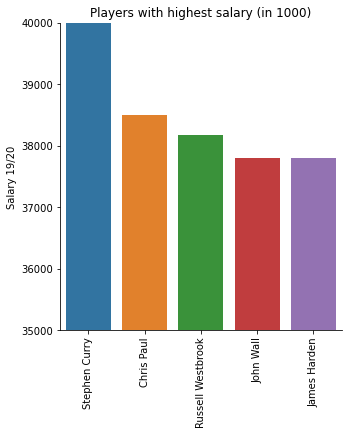

In [20]:
# Setup dataframe
df_sal = df1[['Player', 'Salary 19/20']]
df_sal.sort_values(by = 'Salary 19/20', ascending = False, inplace = True)

# Create barchart
sns.catplot(x = 'Player', y = 'Salary 19/20', kind = 'bar', data = df_sal.head()).set(xlabel = None)
plt.title('Players with highest salary (in 1000)')
plt.ylim([35000, 40000])
plt.xticks(rotation = 90)

A quick summary of the main statistical measures:

In [21]:
# Statistics summary
df1['Salary 19/20'].describe()

count      431.000000
mean      7988.767513
std       9314.626636
min         50.000000
25%       1677.794500
50%       3551.100000
75%      11589.559500
max      40231.758000
Name: Salary 19/20, dtype: float64

How does the distribution look like?

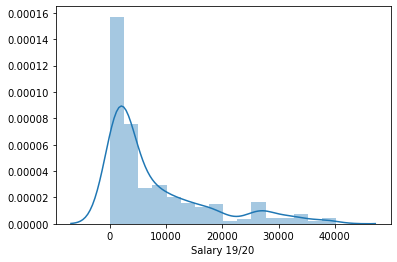

In [22]:
# Histogram
sns.distplot(df1['Salary 19/20'])

**What are the insights?**

1. Large standard deviation which means that the salary is spread out
2. Salary is not normally distributed
3. Right-skewed distribution

For most of the prediction models it is important that the data is normally distributed. Let us keep that in mind when building up the model.

## Analysis of most important player stats

Now let us look at the variables that most probably explain a large part of the salary of NBA players. We are going to focus on points, assists, steals and rebounds per game of the season 18/19.

**What are the leaders in each category?**

[Text(0, 0.5, '')]

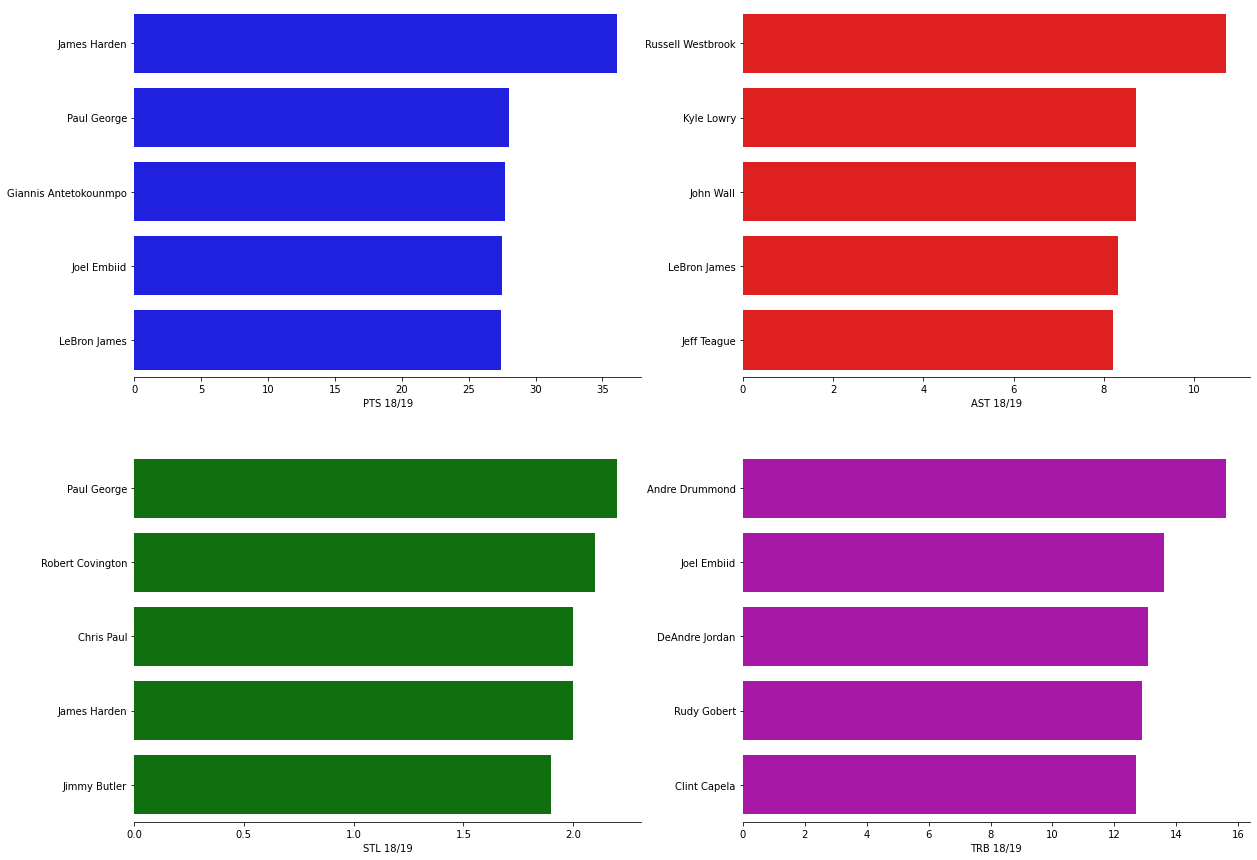

In [23]:
# Setup dataframes
df_pts = df1[['Player', 'PTS 18/19']]
df_pts.sort_values(by = 'PTS 18/19', ascending = False, inplace = True)
df_ast = df1[['Player', 'AST 18/19']]
df_ast.sort_values(by = 'AST 18/19', ascending = False, inplace = True)
df_stl = df1[['Player', 'STL 18/19']]
df_stl.sort_values(by = 'STL 18/19', ascending = False, inplace = True)
df_trb = df1[['Player', 'TRB 18/19']]
df_trb.sort_values(by = 'TRB 18/19', ascending = False, inplace = True)

# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.despine(left=True)

# Create barcharts
sns.barplot(x = 'PTS 18/19', y = 'Player', data = df_pts.head(), color = "b", ax = axes[0, 0]).set(ylabel = None)
sns.barplot(x = 'AST 18/19', y = 'Player', data = df_ast.head(), color = "r", ax = axes[0, 1]).set(ylabel = None)
sns.barplot(x = 'STL 18/19', y = 'Player', data = df_stl.head(), color = "g", ax = axes[1, 0]).set(ylabel = None)
sns.barplot(x = 'TRB 18/19', y = 'Player', data = df_trb.head(), color = "m", ax = axes[1, 1]).set(ylabel = None)

**How do the distributions look like?**

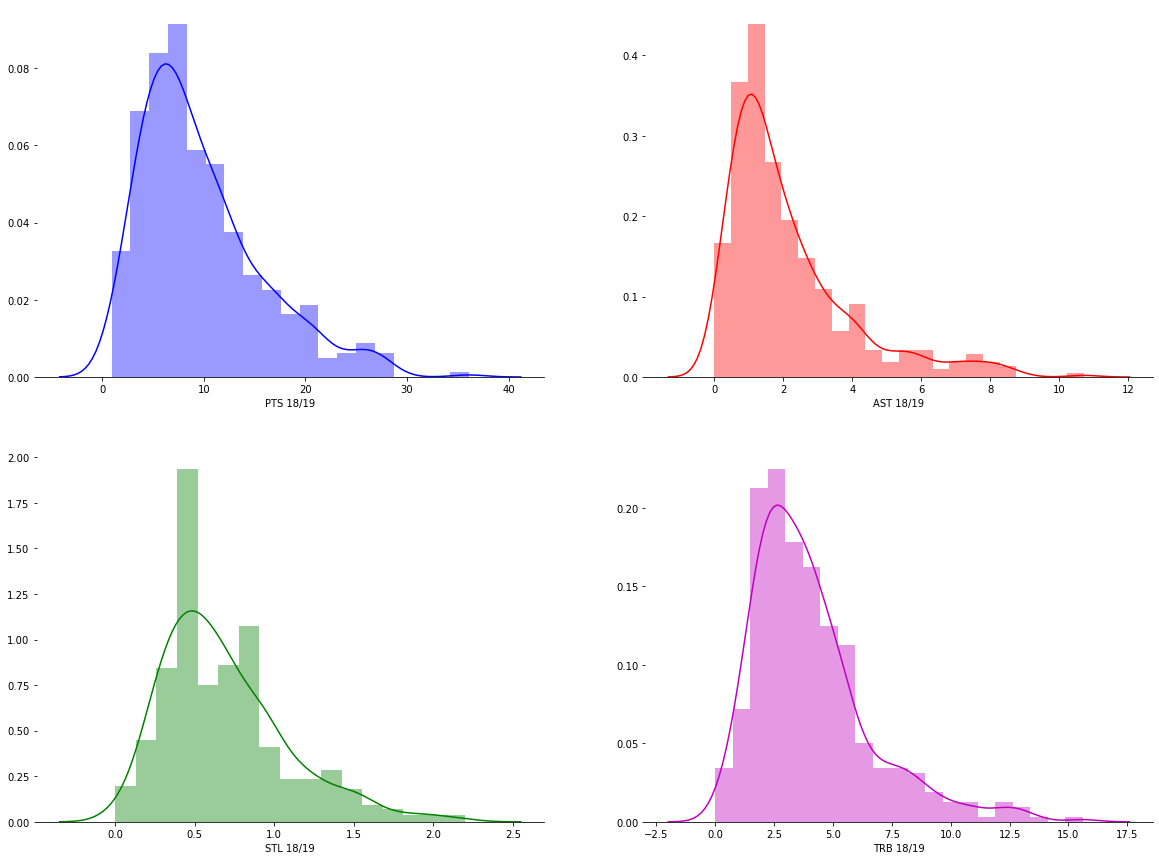

In [24]:
# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.despine(left=True)

# Histograms
sns.distplot(df1['PTS 18/19'], color = "b", ax = axes[0, 0])
sns.distplot(df1['AST 18/19'], color = "r", ax = axes[0, 1])
sns.distplot(df1['STL 18/19'], color = "g", ax = axes[1, 0])
sns.distplot(df1['TRB 18/19'], color = "m", ax = axes[1, 1])

The most important statistics in basketball are also not normally but right-skewed distributed.

**Relationship with possible features**

Let us see how the relationship between some of the most important statistics in basketball and salary looks like. For now we will only focus on the statistics of the season 2018/19. Again we will look at the relationship with points, assists, steals and rebounds per game.

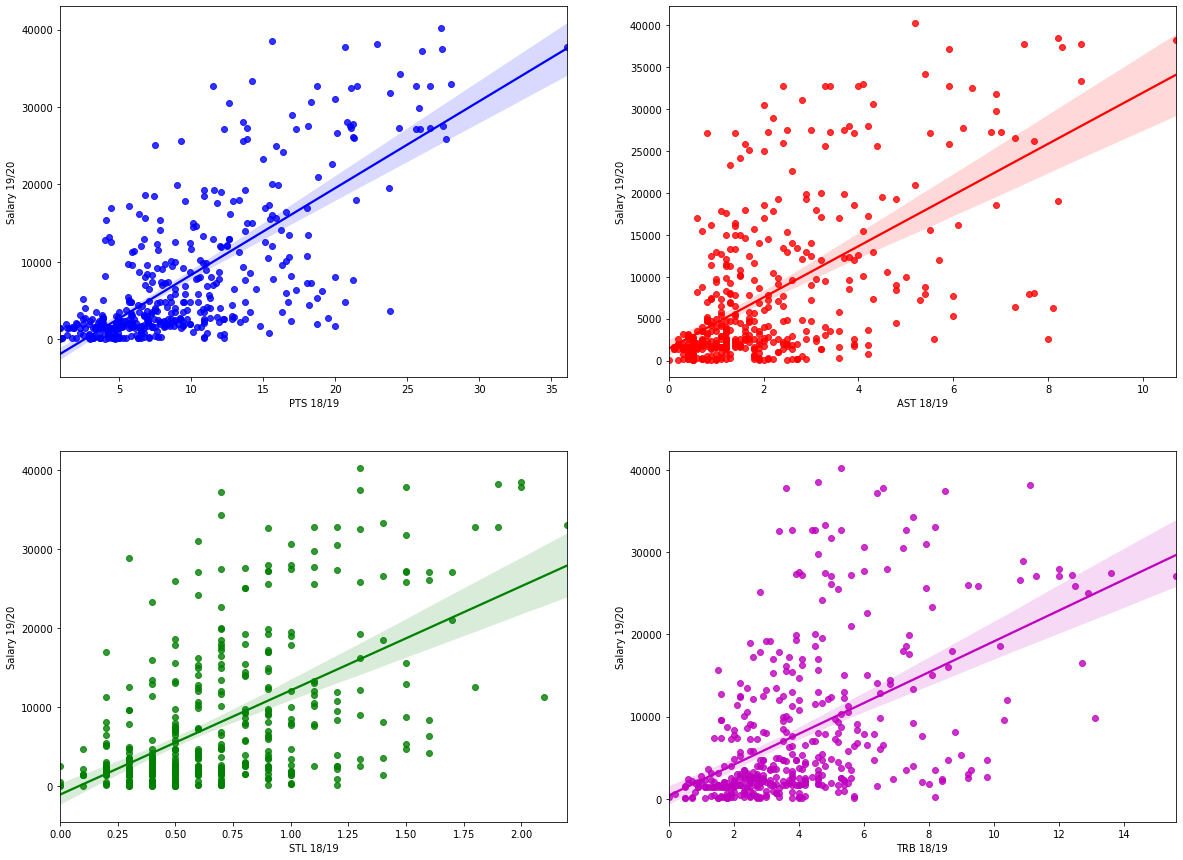

In [25]:
# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))

# Regressionplot
sns.regplot(x = df1['PTS 18/19'], y = df1['Salary 19/20'], color="b", ax=axes[0, 0])
sns.regplot(x = df1['AST 18/19'], y = df1['Salary 19/20'], color="r", ax=axes[0, 1])
sns.regplot(x = df1['STL 18/19'], y = df1['Salary 19/20'], color="g", ax=axes[1, 0])
sns.regplot(x = df1['TRB 18/19'], y = df1['Salary 19/20'], color="m", ax=axes[1, 1])

As one would expect there is a positive linear relationship between all these features and the salary.

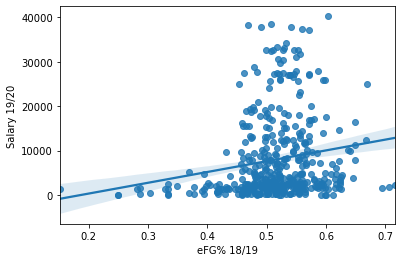

In [26]:
# Relationship with effecitve field goal percentage
sns.regplot(x = df1['eFG% 18/19'], y = df1['Salary 19/20'])

We chose effective field goal percentage instead of normal field goal percentage because it accounts for the fact that three-point field goals count for three points while field goals only count for two points. Here we can hardly observe a positive linear relationship. There are players with a high eFG% but with low salaries. But there are no players with a low eFG% and a high salary.

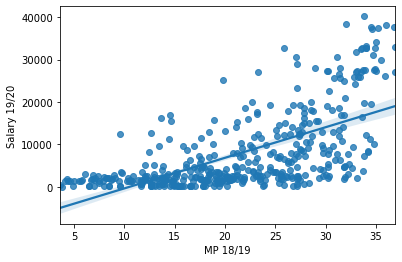

In [27]:
# Relationship with minutes played per game
sns.regplot(x = df1['MP 18/19'], y = df1['Salary 19/20'])

There is also a positive relationship with minutes played per game. It is possibly an exponential relationship. But we need to be careful when analysing this relationship. One can assume that good stats cause a higher salary in the following season and at the same time more minutes per game. Therefore the reason for this positive relationship are most probably the stats.  

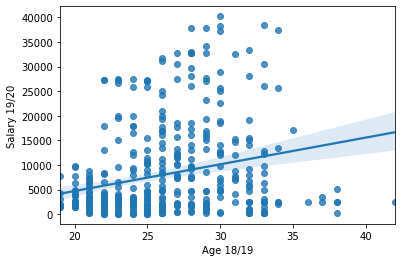

In [28]:
# Relationship with age
sns.regplot(x = df1['Age 18/19'], y = df1['Salary 19/20'])

We can say that there is no linear relationship between age and salary.

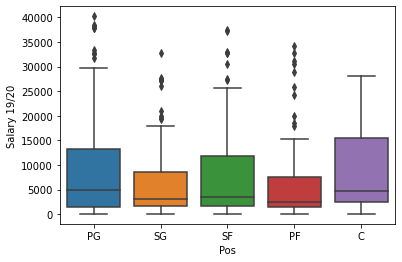

In [29]:
# Relationship with Position
sns.boxplot(x = 'Pos', y = 'Salary 19/20', data = df1, order = ['PG', 'SG', 'SF', 'PF', 'C'])

Therefore we can say that it is not possible to identify any order or correlation. This is important for Encoding this variable later on.

**Correlation matrix**

The analysis until now was based on our intuition and what we think is important for explaining salary. Let us do a more objective analysis and get a perfect overview of all relationships of our variables. Therefore we will use a heatmap.

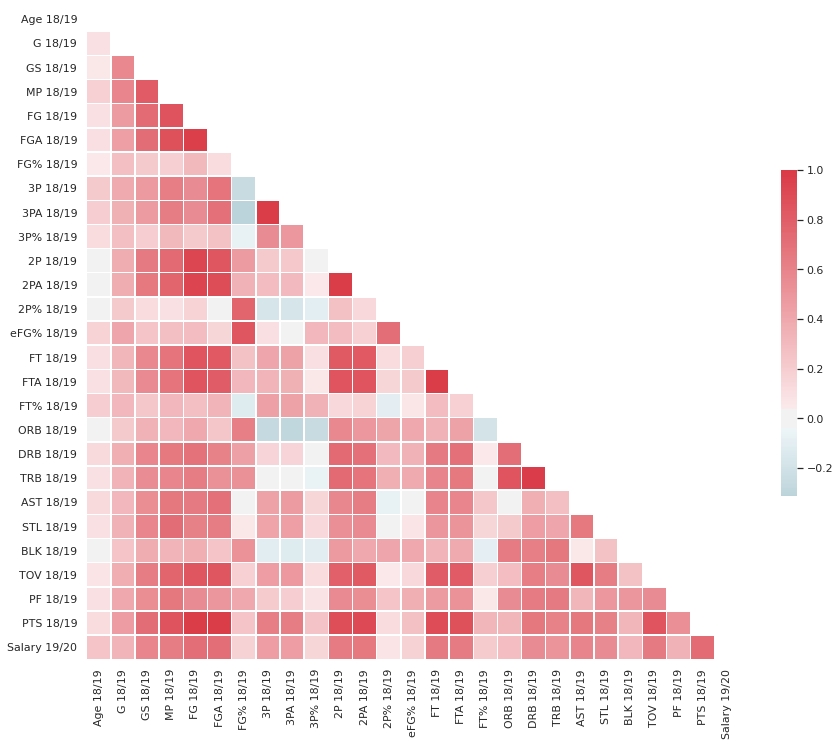

In [30]:
sns.set(style = "white")
cor_matrix = df1.loc[:, 'Age 18/19': 'Salary 19/20'].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))

plt.figure(figsize = (15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

**Again: What are the insights?**

1. Multicollinearity:

The first thing we can observe in this triangular heatmap is that there are a lot of red coloured squares. This is an important information for our prediction model. These variables with such a high correlation give almost the same information to our prediction model and would only raise the variance of our estimation. We have to keep that in mind when building up the model.



2. Correlations with Salary 2019/20:

As we already analysed there is a linear relationship between salary and the four main stats per game. But there are also other variables that should be taken into account. For example fouls per game (PF 18/19) play a big role for explaining the salary. 

We have to be careful when analysing the correlation of salary and minutes played (MP) and games started (GS). We can not simply say that players who play more automatically earn more. As the offensive and defensive stats determine how long the coach lets the player in the game and also determine the salary of next season the relationship is not causal. What we can use in our model is total games played (G). This statistic can for example measure the relationship of a players vulnerability and his salary.

We can also not say that more Turnovers (TOV) lead to a higher salary because of the high correlation. This is of course not the case. A player with good offensive and defensive stats gets more playing time and also a higher salary. It is therefore more reasonable to say that good players with high salary have more turnovers on average because they get more playing time. 

**What about the relationship between the absolute changes and salary?**

It would be interesting to know if this also plays a role. A player who was performing better in season 18/19 than 17/18 and therefore is expected to get even better might have a higher salary. Let us have a look.

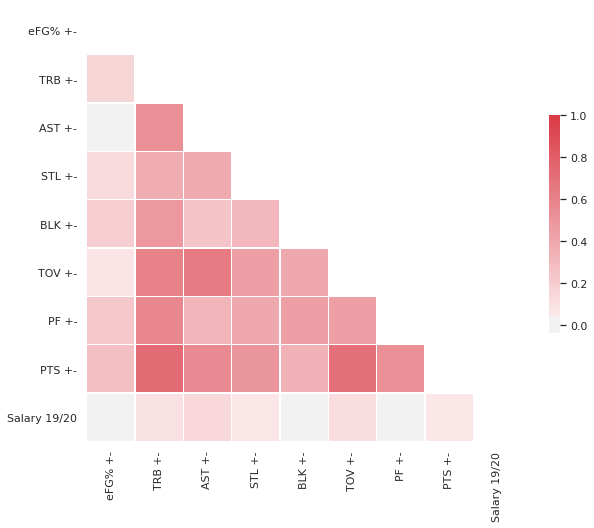

In [31]:
cor_matrix = df2.loc[:, ['eFG% +-','TRB +-', 'AST +-', 'STL +-', 'BLK +-', 'TOV +-', 'PF +-', 'PTS +-', 
                        'Salary 19/20']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))

plt.figure(figsize = (10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

There seem to be weak positive to no linear relationships between the absolute changes and salary. That is why we will leave out the absolute changes and therefore the stats of season 17/18 in our prediction model.

# 3. Data Preparation

**Define target variable and features**

In [32]:
y = df1.loc[:, 'Salary 19/20']

x = df1.loc[:, ['Pos', 'Age 18/19', 'G 18/19', 'GS 18/19', 'MP 18/19', 'FG 18/19', 'FGA 18/19',
                'FG% 18/19', '3P 18/19', '3PA 18/19', '2P 18/19', '2PA 18/19', '2P% 18/19', 
                'eFG% 18/19', 'FT 18/19', 'FTA 18/19', 'ORB 18/19', 'DRB 18/19', 'TRB 18/19', 
                'AST 18/19', 'STL 18/19', 'BLK 18/19', 'TOV 18/19', 'PF 18/19', 'PTS 18/19']] 

print(x.shape)
print(y.shape)

(431, 25)
(431,)


**One-Hot encoding for feature position**

We will use the One-Hot encoder to deal with the categorical variable 'Pos_x'. We can not use the normal Label encoder because an ordering would tell our algorithm that certain positions are 'better' than others. 

In [33]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(categories = [['PG', 'SG', 'SF', 'PF', 'C']])

# Apply one-hot encoder
x_ohe = pd.DataFrame(ohe.fit_transform(x['Pos'].to_frame()).toarray())

# Get feature names
x_ohe.columns = ohe.get_feature_names(['Pos'])

# One-hot encoding removed index; put it back
x_ohe.index = x.index

# Add one-hot encoded columns to numerical features and remove categorical column
x = pd.concat([x, x_ohe], axis=1).drop(['Pos'], axis=1)

# How does it look like?
x.head()

,Age 18/19,G 18/19,GS 18/19,MP 18/19,FG 18/19,FGA 18/19,FG% 18/19,3P 18/19,3PA 18/19,2P 18/19,...,STL 18/19,BLK 18/19,TOV 18/19,PF 18/19,PTS 18/19,Pos_PG,Pos_SG,Pos_SF,Pos_PF,Pos_C
0,25.0,80.0,80.0,33.4,6.0,10.1,0.595,0.0,0.0,6.0,...,1.5,1.0,1.7,2.6,13.9,0.0,0.0,0.0,0.0,1.0
1,21.0,82.0,28.0,23.3,3.4,5.9,0.576,0.0,0.2,3.4,...,0.9,0.8,1.5,2.5,8.9,0.0,0.0,0.0,0.0,1.0
2,33.0,81.0,81.0,33.2,8.4,16.3,0.519,0.1,0.5,8.3,...,0.5,1.3,1.8,2.2,21.3,0.0,0.0,0.0,0.0,1.0
3,20.0,80.0,80.0,26.2,4.2,7.1,0.590,0.1,0.6,4.1,...,0.5,1.5,1.3,2.3,10.9,0.0,0.0,0.0,0.0,1.0
4,28.0,81.0,81.0,28.3,3.2,7.3,0.433,1.2,3.5,2.0,...,0.8,0.4,0.9,1.8,9.4,0.0,0.0,0.0,1.0,0.0


**Split Data into train and test**

In [34]:
# Split data using train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(344, 29)
(344,)
(87, 29)
(87,)


**Normalise y**

As we saw in our analysis the dependent variable does not approximately follow a normal distribution, but it is necessary for most of our models. That is why we need to normalise y for the next steps.

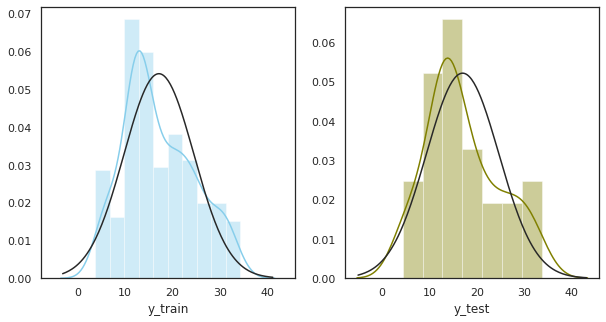

In [35]:
#Apply cube-root transformation
y_train = pd.DataFrame(np.cbrt([y_train])).T
y_test = pd.DataFrame(np.cbrt([y_test])).T
y = pd.DataFrame(np.cbrt([y])).T

#transformed histogram and normal probability plot
f, axes = plt.subplots(1, 2, figsize = (10, 5), sharex = True)
sns.distplot(y_train, color = "skyblue", fit = norm, ax = axes[0], axlabel = "y_train")
sns.distplot(y_test, color = "olive",fit = norm, ax = axes[1], axlabel = "y_test")
#sns.distplot(y, color = "olive",fit = norm, axlabel = "y")

**Scaling features**

For some of our following algorithms it is important that our features are scaled.

In [36]:
# Use Robustscaler

#scaler = RobustScaler()
#x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
#x_test_scaled = pd.DataFrame(scaler.transform(x_test), index = x_test.index, columns = x_test.columns)

#x_train_scaled.head()

# 4. Building Machine Learning Models

## Basic machine learning algorithms

We will set up a function to prevent wirting similar code repeated times. We will evaluate these models with the root-mean-squared-error and the R-squared.

In [37]:
# Function which uses an algorithm as input and returns the desired accuracy metrics and some predictions

def alg_fit(alg, x_train, y_train, x_test, name, y_true, df, mse, r2):
    
    # Model selection
    mod = alg.fit(x_train, y_train)
    
    # Prediction
    y_pred = mod.predict(x_test)
    
    # Accuracy
    acc1 = round(mse(y_test, y_pred), 4)
    acc2 = round(r2(y_test, y_pred), 4)
    
    # Accuracy table
    x_test['y_pred'] = mod.predict(x_test)
    df_acc = pd.merge(df, x_test, how = 'right')
    x_test.drop(['y_pred'], axis = 1, inplace = True)
    df_acc = df_acc[[name, y_true, 'y_pred']]
    df_acc.sort_values(by = y_true, ascending = False, inplace = True)
    df_acc['y_pred'] = df_acc['y_pred']**3
    
    return y_pred, acc1, acc2, df_acc

**Linear Regression**

We will start and test a simple linear regression model.

In [38]:
# Linear Regression
y_pred_lin, mse_lin, r2_lin, df_acc_lin = alg_fit(LinearRegression(), x_train, y_train, x_test, 'Player', 'Salary 19/20', 
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_lin), 4))
print("R-squared: %s" % r2_lin)
df_acc_lin.head(10)

Root Mean Squared Error: 4.8398
R-squared: 0.5995


,Player,Salary 19/20,y_pred
80,Russell Westbrook,38178.000,35861.722038
77,John Wall,37800.000,15151.551058
51,Blake Griffin,34234.964,22661.860956
19,Kawhi Leonard,32742.000,27317.865101
104,Nikola Vučević,28000.000,34595.453560
98,Al Horford,28000.000,18990.550807
53,Andre Drummond,27093.019,20183.882351
0,Jrue Holiday,26131.111,26692.191478
4,Giannis Antetokounmpo,25842.697,18709.435310
10,Nicolas Batum,25565.217,10365.910602


**Ridge Regression**

As we have a problem of multicollinearity in our linear regression model, we need to find a fitting solution. With high multicollinearity our estimation is most probably imprecise and has large standard errors. 
Ridge regression mitigates this problem by providing improved efficiency in our estimation in exchange for an amount of bias. 

In [39]:
# Ridge Regression
y_pred_rid, mse_rid, r2_rid, df_acc_rid = alg_fit(Ridge(alpha = 1), x_train, y_train, x_test, 'Player', 'Salary 19/20',
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_rid), 4))
print("R-squared: %s" % r2_rid)
df_acc_rid.head(10)

Root Mean Squared Error: 4.7957
R-squared: 0.6068


,Player,Salary 19/20,y_pred
80,Russell Westbrook,38178.000,37299.368076
77,John Wall,37800.000,15077.459654
51,Blake Griffin,34234.964,22222.230027
19,Kawhi Leonard,32742.000,27533.144275
104,Nikola Vučević,28000.000,35387.892650
98,Al Horford,28000.000,18659.381273
53,Andre Drummond,27093.019,21340.393930
0,Jrue Holiday,26131.111,26024.180424
4,Giannis Antetokounmpo,25842.697,20373.840488
10,Nicolas Batum,25565.217,10390.245816


**Lasso Regression**

The lasso regression is quite similar conceptually to ridge regression. It additionally adds a penalty for non-zero coeffecients. Unlike ridge regression it limits the absolute values of the coefficients rather than the sum of squared coefficients.

In [40]:
# Lasso Regression
y_pred_las, mse_las, r2_las, df_acc_las = alg_fit(Lasso(alpha = 0.001), x_train, y_train, x_test, 'Player', 'Salary 19/20',
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_las), 4))
print("R-squared: %s" % r2_las)
df_acc_las.head(10)

Root Mean Squared Error: 4.7956
R-squared: 0.6068


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3124.795096794169, tolerance: 1.870867104030862
  positive)


,Player,Salary 19/20,y_pred
80,Russell Westbrook,38178.000,35342.454510
77,John Wall,37800.000,14744.765409
51,Blake Griffin,34234.964,22565.965812
19,Kawhi Leonard,32742.000,27308.015452
104,Nikola Vučević,28000.000,34492.761274
98,Al Horford,28000.000,18595.284756
53,Andre Drummond,27093.019,20516.650394
0,Jrue Holiday,26131.111,26103.685756
4,Giannis Antetokounmpo,25842.697,19036.876429
10,Nicolas Batum,25565.217,10506.957046


### Cross Validation

This will give us a more precise accuracy measure.

In [41]:
def alg_fit_cv(alg, x, y, mse, r2):
    
    # Cross validation
    cv = KFold(shuffle = True, random_state = 0, n_splits = 5)
    
    # Accuracy
    scores1 = cross_val_score(alg, x, y, cv = cv, scoring = mse)
    scores2 = cross_val_score(alg, x, y, cv = cv, scoring = r2)
    acc1_cv = round(scores1.mean(), 4)
    acc2_cv = round(scores2.mean(), 4)
    
    return acc1_cv, acc2_cv

In [42]:
# Linear Regression

mse_cv_lin, r2_cv_lin = alg_fit_cv(LinearRegression(), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_lin*-1), 4))
print("R-squared: %s" % r2_cv_lin)

Root Mean Squared Error: 5.0776
R-squared: 0.5217


In [43]:
# Ridge Regression
mse_cv_rid, r2_cv_rid = alg_fit_cv(Ridge(alpha = 23), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_rid*-1), 4))
print("R-squared: %s" % r2_cv_rid)

Root Mean Squared Error: 5.023
R-squared: 0.5342


In [44]:
# Lasso Regression
mse_cv_las, r2_cv_las = alg_fit_cv(Ridge(alpha = 23), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_las*-1), 4))
print("R-squared: %s" % r2_cv_las)

Root Mean Squared Error: 5.023
R-squared: 0.5342


## Advanced models

Let us use more advanced approaches.

In [45]:
# LightGBM Regressor (after some parameter tuning)
lgbm = LGBMRegressor(objective = 'regression',
                     num_leaves = 20,
                     learning_rate = 0.03,
                     n_estimators = 200,
                     max_bin = 50,
                     bagging_fraction = 0.85,
                     bagging_freq = 4,
                     bagging_seed = 6,
                     feature_fraction = 0.2,
                     feature_fraction_seed = 7,
                     verbose = -1)

mse_cv_lgbm, r2_cv_lgbm = alg_fit_cv(lgbm, x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_lgbm*-1), 4))
print("R-squared: %s" % r2_cv_lgbm)

Root Mean Squared Error: 5.0839
R-squared: 0.5218


In [46]:
# XGB-Regressor (after some parameter tuning)
xgb = XGBRegressor(n_estimators = 300,
                   max_depth = 2,
                   min_child_weight = 0,
                   gamma = 8,
                   subsample = 0.6,
                   colsample_bytree = 0.9,
                   objective = 'reg:squarederror',
                   nthread = -1,
                   scale_pos_weight = 1,
                   seed = 27,
                   learning_rate = 0.02,
                   reg_alpha = 0.006)

mse_cv_xgb, r2_cv_xgb = alg_fit_cv(xgb, x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_xgb*-1), 4))
print("R-squared: %s" % r2_cv_xgb)

Root Mean Squared Error: 4.8883
R-squared: 0.5613


## Optimizing our data and features

**Outliers**

In [47]:
# Merge y and x back together
#df_new = pd.concat([y, x], axis=1)

# Compute Z-score for the dataframe
#z = np.abs(stats.zscore(df_new))

# Delete rows with outliers
#df_new = df_new[(z < 4).all(axis = 1)].reset_index()

# Split into y and x again
#y_new = df_new.loc[:, 0]
#x_new = df_new.loc[:, 'PTS 18/19':] 
#print(x_new.shape)
#print(y_new.shape)

**Feature importance**

We will use the XGB-Regressor to detect the most important features as it had the best accuracy score so far.

In [48]:
# Model
mod = xgb.fit(x, y)

# Feature importance
df_feature_importance = pd.DataFrame(xgb.feature_importances_, index = x.columns, 
                                     columns = ['feature importance']).sort_values('feature importance', 
                                                                                   ascending = False)
df_feature_importance

,feature importance
MP 18/19,0.140423
FG 18/19,0.122429
PTS 18/19,0.095819
TOV 18/19,0.085521
FGA 18/19,0.047154
FT 18/19,0.042282
2PA 18/19,0.039820
DRB 18/19,0.039678
GS 18/19,0.037827
AST 18/19,0.028416


**New features**

We will use the features with high importance. Some features can't be used as they are redundant or close to another feature. For example field goals per game (FG 18/19) is not necessary as we already have pionts per game (PTS 18/19).

In [49]:
# Drop out features with low importance or which are redundant
x_new = x.loc[:, ['PTS 18/19', 'Pos_PG', 'Pos_SG', 'Pos_SF', 'Pos_PF', 'Pos_C', 'Age 18/19', 'STL 18/19', 
                  'G 18/19', 'TRB 18/19', 'AST 18/19', 'PF 18/19', 'MP 18/19']]

## Final Model 

In [50]:
# XGB-Regressor (after some parameter tuning)
xgb_new = XGBRegressor(n_estimators = 270,
                       max_depth = 2,
                       min_child_weight = 0,
                       gamma = 18,
                       subsample = 0.7,
                       colsample_bytree = 0.9,
                       objective = 'reg:squarederror',
                       nthread = -1,
                       scale_pos_weight = 1,
                       seed = 27,
                       learning_rate = 0.023,
                       reg_alpha = 0.02)

mse_cv_xgb, r2_cv_xgb = alg_fit_cv(xgb_new, x_new, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_xgb*-1), 4))
print("R-squared: %s" % r2_cv_xgb)

Root Mean Squared Error: 4.7413
R-squared: 0.5885


**Let's see how it performs on some test data**

In [51]:
# Split data now with x_new
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2, random_state = 0)

# Use function to fit algorithm
y_pred_xgb, mse_xgb, r2_xgb, df_acc_xgb = alg_fit(xgb_new, x_train, y_train, x_test, 'Player', 'Salary 19/20', 
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_xgb), 4))
print("R-squared: %s" % r2_xgb)
df_acc_xgb.head(10)

Root Mean Squared Error: 4.6793
R-squared: 0.6256


,Player,Salary 19/20,y_pred
80,Russell Westbrook,38178.000,37120.562500
77,John Wall,37800.000,23882.886719
51,Blake Griffin,34234.964,30581.968750
19,Kawhi Leonard,32742.000,30710.667969
104,Nikola Vučević,28000.000,26982.714844
98,Al Horford,28000.000,15906.945312
53,Andre Drummond,27093.019,21377.617188
0,Jrue Holiday,26131.111,33649.562500
4,Giannis Antetokounmpo,25842.697,20042.300781
10,Nicolas Batum,25565.217,11423.502930
